# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data['income'].count()

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K']['income'].count()

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K']['income'].count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k)/float(n_records) * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

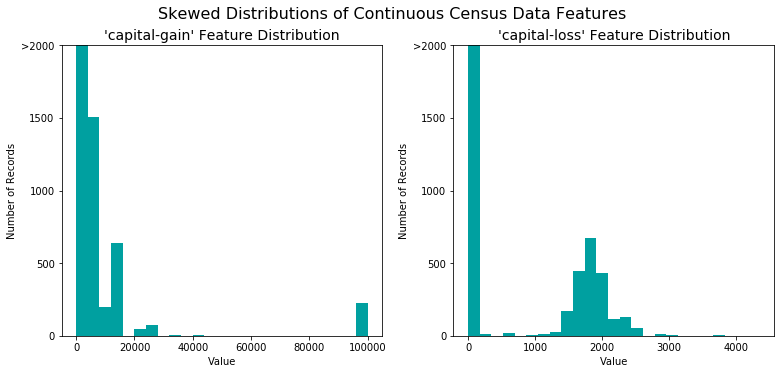

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

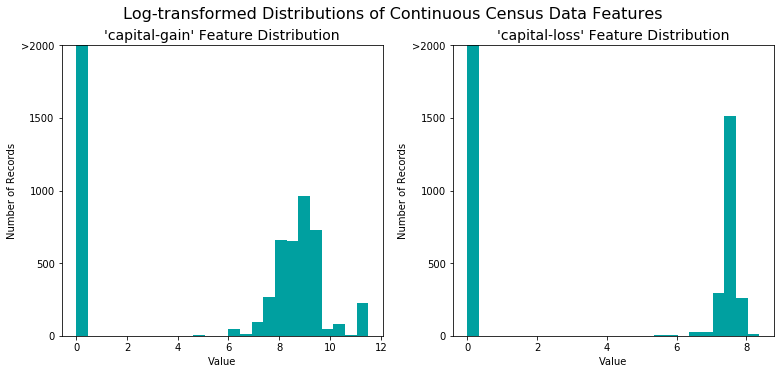

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income_raw.loc[income_raw == '>50K'] = 1
income_raw.loc[income_raw == '<=50K'] = 0
income = income_raw

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


/Users/zack/.vms/ml-nano/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
import math
# TODO: Calculate accuracy
accuracy = float(n_greater_50k)/n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
precision = float(n_greater_50k)/n_records
recall = float(n_greater_50k)/n_greater_50k
fscore = (1+math.pow(beta,2)) * ((precision*recall)/(math.pow(beta,2)*precision + recall))

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

### Gradient Boosting Classifier

1. Gradient boosting and random forrests have been applied to predict how people will respond to direct marketing offers. This would be a useful model for a business that conducts direct marketing for a few reasons. First, you don't want to annoy customer's who don't respond well to direct marketing. Second, you don't want to waste resources doing direct marketing to customer's who won't respond well. And Third, a lot of direct marketing involves offering coupons and discounts, so you don't want to send someone who is willing to pay full price a coupon, you only want to send people who are unwilling to pay at the current price, but would give it a try if the price were lowered a bit.     
    http://content.library.ccsu.edu/cdm/ref/collection/ccsutheses/id/1922

2. Ensemble methods perform well almost all of the time, but they perform especially well compared to other learning algorithms when features are not linear, in high-dimensional spaces, and with lots of training data. In fact, the more training data that you have, the better your model will predict on average. Gradient boosting is resistant to overfittign because it uses an ensemble of weak learners, each of which are not overfit. 

3. The only time ensemble methods really perform poorly is when the underlying weak learners are overfit (which happens in low dimensional spaces) or when there is not sufficient training data. 

4. Ensemble methods are a good choice for this data set because we have a pretty high enough space after one-hot encoding (106) and a good amount of training data (~36,000 rows). We also know that at least a few of the features aren't distributed linearly, and some of the features might not intereact with other features linearly, so ensembling decision trees is a safe bet.

### Decision Trees

1. Decision trees have been applied to numerous problems over the years. In general, they are used less these days as newer methods and algorithms have been invented, such as bagging and boosting sets of decision trees. One example of a real-world application was labeling text with parts of speech. 
    http://dl.acm.org/citation.cfm?id=1075554

2. Decision trees perform well in medium/high-dimensional spaces and with non-linear features/interactions. They are also highly interpretable and easy to explain to non-technical coworkers. 

3. Decision trees aren't as good at modeling complex data without overfitting as methods that ensemble them.

4. A decision tree is a decent choice for this problem because we have enough dimensions and data that other algorithms are less viable because of speed (SVM), and we likely have non-linear features and interactions (which rules out NB, regression, SGDC, etc.). The decision tree obviously won't be the best model because the boosted ensemble will be able to capture more complexity without overfitting.

### KNN

1. KNN has been used for intrusion detection and can achieve a low false positive rate. 
    http://www.sciencedirect.com/science/article/pii/S016740480200514X

2. KNN performs well in low-dimensional spaces. I read in a scholarly ariticle that the nearest and furthest neightbors can start to converge with as few as 15 features. It can also model non-linear features/interactions.

3. KNN performs poorly in high-dimensional spaces as the nearest and furthest neighbors become more indistinguishable. It also performs poorly with large datasets. 

4. KNN is an ok choice for this dataset because the dimensionality is low enough and we don't have too much data. We don't have thousands of features like we might in text-based models and 106 dimensions isn't so bad that the speed and performance will be terrible. The gradient boosted classifier will still be a better choice. 



### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], list(y_train[:sample_size].values))
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(list(y_train[:300].values), list(predictions_train))
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(list(y_test.values), list(predictions_test))
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(list(y_train[:300].values), list(predictions_train), beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(list(y_test.values), list(predictions_test), beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


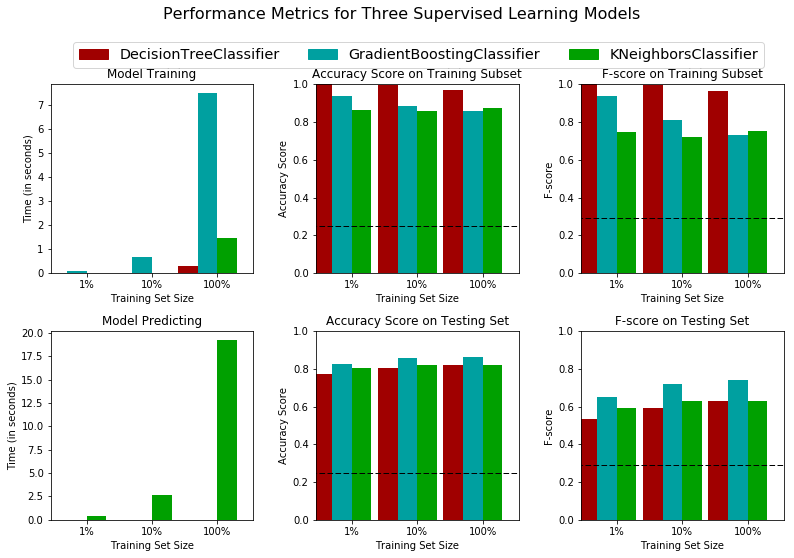

In [10]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the three models
clf_A = GradientBoostingClassifier(random_state=0)
clf_B = KNeighborsClassifier()
clf_C = DecisionTreeClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(y_train.count()*0.01)
samples_10 = int(y_train.count()*0.1)
samples_100 = y_train.count()

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

I would recommend the boosted decision tree ensemble for a number of reasons. While it takes the most time to train, it is very efficient at predicting. Since There are potentially millions of people that ChairityML would like to analyze as possible donors, we are going to want a model that predicts quickly. In terms of prediction performance, the tree ensemble was best at predicting the test set when measured on both accuracy and F-score. Finally, the tree ensemble fits the data best. It performs well on high dimensional spaces with lots of training data and non-linear features, which matches up pretty well with the ChairtyML dataset. We could even improve our prediciton power more by collecting and adding more training data in the future.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

The model that we have created for you uses a strategy of combining many small and simple models into a more complex model. Research shows that combining many simple models generalizes and make predictions better than a single, more complicated model. 

Each of the simple models are called decision trees and they try to learn simple true or false rules about the data to imply whether or not someone makes at least \$50k/yr. For example, one of the simple models might try to decide how to make a prediction based on how much education someone has. It will figure out the education score that best splits people who earn more than $50k/yr and those who don't. All of the simple models take slightly different approaches for trying to predict the data and in the end we combine them all together into one model that has more predictive power than the sum of its parts. 

Sometimes when you combine all of the simple models into the final, complex model you allow each model to vote and the outcome with the most votes becomes the model prediction. In this case, we took our model a step further using something called boosting. After each simple model is built, and before moving on to creating the next simple model, we look at which data points our model is currently worst at predicting. Then, when we create the next simple model we give the points that we are predicting poorly more weight so that the new model focuses more on predicting those accurately. In this way after hundreds or thousands of iterations, we end up with a big collection of simple models that at each step along the way have focused on modeling what we were worst at predicting. Research shows that this method typically achieves better results than the simpler voting method of combining the simple models. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [19]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=2017)

# TODO: Create the parameters list you wish to tune
parameters = {
    'learning_rate': [0.05, 0.1, 0.15], 
    'n_estimators': [100, 500, 1000], 
    'max_depth': [2, 3, 5], 
    'min_samples_split': [2, 5, 7],
    'max_features': [None, 2, 5]
}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer, n_jobs=7)

# TODO: Fit the grid search object to the training data and find the optimal parameters
print 'starting search'
grid_fit = grid_obj.fit(features, list(income.values))
print 'finished search'

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, list(y_train.values))).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(list(y_test.values), predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(list(y_test.values), predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(list(y_test.values), best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(list(y_test.values), best_predictions, beta = 0.5))

starting search
finished search
Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8747
Final F-score on the testing data: 0.7617


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.2478          |   0.8630          |      0.8747      |
| F-score        |          0.2917     |      0.7395       |   0.7617       |


**Answer: **

Both the unoptimized and optimized models are significantly better than simply predicting that everyone makes greater than $50k. The unoptimized gradient boosted trees did a really good job even without parameter tuning. 

I tried large set of different parameters for grid search to optimize over and the best combo was `max_features=None`, `min_samples_split=7`, `learning_rate=0.1`, `n_estimators=1000`, and `max_depth=2`. This optimized model outperformed the unoptimized model when judeged by both accuracy and our F-score with `beta=0.5`. The accuracy only improved slightly from the unoptimized model, but the F-score improved by much more, which makes sense since grid search was optimizing on the F-score not the accuracy. 


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

### 1. Capital Gains

Out of all the features that we have at our disposal, capital gains is the only one that is tied directly to a person's income. In order to have money to save, invest, and earn capital gains, you need disposible income and likely make over $50k. I'm not sure whether or not capital gains income counts in the total income we are trying to predict, but if it does this would surly be a strong predictor. 

### 2. Occupation

A person's occupation is determined by their skillset and experience and should be a strong indicator of how in demand they are, and thus their income level. I don't think that occupation will be as strong of a predictor as capital gains, but salaries for types of jobs typically fall within a predictable range and should help us predict whether or not people make over $50k.

### 3. Education Num

It's a well-known fact that your potential to earn more money goes up as you become more educated; that's why I'm taking this course! I don't think that education num will be as strong of a predictor as capital gains or occupation because there are a lot of fields where you can be highly educated, but still not make that much money; anything in the arts or social services would apply. It's also not a given that you are employable even if you have a high level of education. I chose to use education num instead of education level because it is more granular and I did not include both on my list because I suspect that they are highly correlated. 

### 4. Age

As you increase in age, you typically earn more money. This is a result of accumulating more skills, experience, and saved income that can be invested and earn more money. Given a set of people with similar education and occupation, I would expect the older people to make more money that the younger people. 

### 5. Native Country

While there are a good number of people who immigrate to the United States and do very well for themselves, it definitely is not an easy road if you are comming from a country outside of Western Europe, Canada, etc. You likely will not have very much education, speak the language, have connections, have family to support you financially, etc. On the flip side, I suspect that people imigrating from wealthy countries like Canada and Western Europe will be better off than the average person. Often what forces people to immigrate from these countries are job opportunities and the typs of jobs that relocate you to different countries usually pay well. 


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

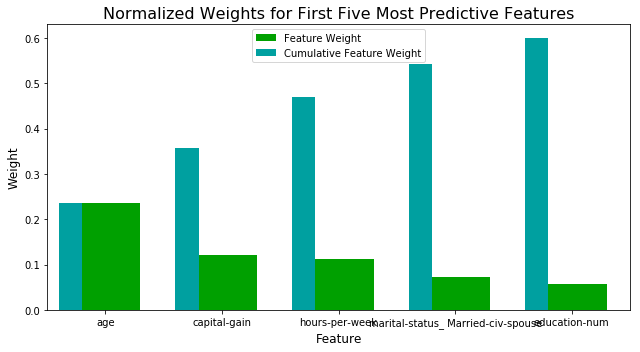

In [24]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier
# TODO: Train the supervised model on the training set 
model = RandomForestClassifier().fit(X_train, list(y_train.values))

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

### 1. Age

Like I mentioned before, it makes sense that age is a strong predictor of income because older people have more skills and experience, which are big factors in determining a person's salary given an occupation.

### 2. Capital gains

In order to earn capital gains you need to make enough money that some is left over to save. Capital gains are also a form of income, so if you have more capital gains you will have a higher income.

### 3. Hours per week

I did not have this feature in my predictions, but it makes sense; the more you work the more you make. I am a little surprised that occupation wasn't more important, but after looking closer at the possible values of occupation I saw that there were only a few broad categories for occupation to fall into, so it makes more sense why it wasn't a strong predictor for income.

### 4. Married

This one surprised me a little at first, but after thinking about it it makes sense. If the income measurement is household income then it follows that two incomes would be better than one. 

### 5. Education number

Education number was an most important feature, which closely algins with what I predicted. When you are more educated, you have more skills, and when you have more skills, you generally make more money.



### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [29]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, list(y_train.values))

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(list(y_test.values), best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(list(y_test.values), best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(list(y_test.values), reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(list(y_test.values), reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8747
F-score on testing data: 0.7617

Final Model trained on reduced data
------
Accuracy on testing data: 0.8502
F-score on testing data: 0.7054


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

While the accuracy only fell a few percentage points on the reduced data, the f-score fell by almost 6%. Since we are trying to optimize on f-score and not accuracy, I would probably not consider using this model if training time was factor. First off, I don't think that training time is reduced that much in the grand scheme of things and the negative impact on f-score is probably of higher magnitude than the decrease in training time. 

It also doesn't seem like training time should be a huge factor for this model. We shouldn't need to be training models all the time, once they are trianed they will be able to be used for a large number of predictions.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.